In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

In [3]:
import importlib

## Preprocessing
### Read data

In [14]:
data_path = "../../data/BacDrop"
data_all = sc.read_h5ad(data_path + "/klebsiella_all_2_replicates_processed.h5ad")
data_all.X = sps.csr_matrix(data_all.layers["counts"].copy())
data_all

AnnData object with n_obs × n_vars = 68150 × 2000
    obs: 'treatment', 'replicate', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'norm_counts'
    obsp: 'connectivities', 'distances'

<Axes: xlabel='treatment', ylabel='Count'>

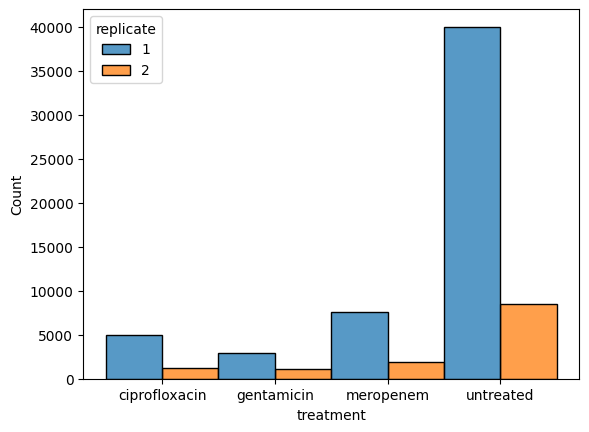

In [15]:
sns.histplot(data_all.obs, x="treatment", hue="replicate", palette="tab10", multiple="dodge")


In [18]:
data_anti = data_all[data_all.obs["treatment"] != "untreated"]
data_anti

View of AnnData object with n_obs × n_vars = 19642 × 2000
    obs: 'treatment', 'replicate', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'norm_counts'
    obsp: 'connectivities', 'distances'

In [19]:
print(f"Zero inflation of whole data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")
print(f"Zero inflation of antibiotics data: {((np.prod(data_anti.X.shape) - data_anti.X.getnnz()) / np.prod(data_anti.X.shape)).round(3)}")


Zero inflation of whole data: 0.993
Zero inflation of antibiotics data: 0.993


### Filter cells

--> filter based on mean absolute standard deviation

In [27]:
importlib.reload(ut)
data_gene = ut.filter_outliers(data_anti, nmads=10, min_cells=2, min_genes=2)
print(data_anti.obs.outlier.value_counts())
print(f"Total number of cells: {data_anti.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

False    19584
True        58
Name: outlier, dtype: int64
Total number of cells: 19642
Number of cells after filtering: 19369


AnnData object with n_obs × n_vars = 19369 × 1716
    obs: 'treatment', 'replicate', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'outlier'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'log1p_mean_counts', 'log1p_total_counts'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'norm_counts'
    obsp: 'connectivities', 'distances'

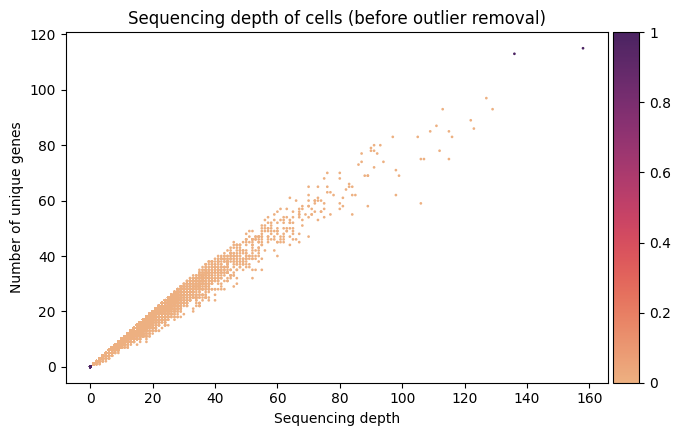

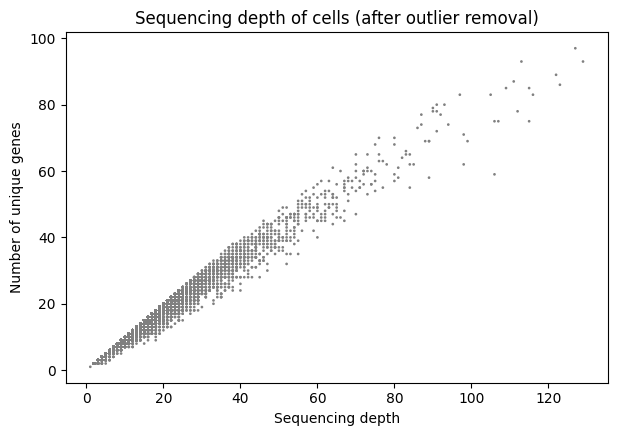

In [28]:
g = sc.pl.scatter(data_anti, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="flare", title="Sequencing depth of cells (before outlier removal)")
g.set(xlabel = "Sequencing depth")
g.set(ylabel="Number of unique genes")
plt.tight_layout()
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [29]:
data_gene.layers["counts"] = data_gene.X.copy()

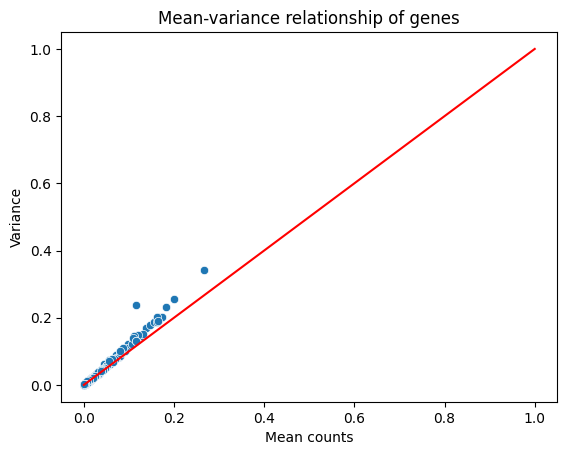

In [30]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

In [31]:
mv_corr_lin = np.corrcoef(data_gene.var["mean_counts"], data_gene.var["var_counts"])[0,1]
mv_corr_sq = np.corrcoef(data_gene.var["mean_counts"]**2, data_gene.var["var_counts"])[0,1]

if mv_corr_sq > mv_corr_lin:
    is_overdispersed = True
else:
    is_overdispersed = False
    
print(is_overdispersed)

False


## Estimate negative binomial parameters for each gene

In [32]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="sctransform")

In [33]:
data_gene.var

n_cells     mt  n_cells_by_counts  mean_counts  \
cds-AF52_RS00275          6  False                  6     0.000310   
cds-AF52_RS0122950        5  False                  5     0.000310   
cds-AF52_RS0123080       11  False                 11     0.000671   
cds-AF52_RS0123140        4  False                  4     0.000207   
cds-AF52_RS0123150       27  False                 27     0.001446   
...                     ...    ...                ...          ...   
cds-WP_171991785.1       23  False                 23     0.001239   
cds-WP_187079186.1       21  False                 21     0.001136   
cds-WP_187079187.1        5  False                  5     0.000413   
cds-WP_187079194.1       39  False                 39     0.002065   
cds-WP_187079196.1       21  False                 21     0.001187   

                    pct_dropout_by_counts  total_counts  highly_variable  \
cds-AF52_RS00275                99.969023           6.0             True   
cds-AF52_RS0122950              99.974186           6.0             True   
cds-AF52_RS0123080              99.943208          13.0             True   
cds-AF52_RS0123140              99.979348           4.0             True   
cds-AF52_RS0123150              99.860602          28.0             True   
...                                   ...           ...              ...   
cds-WP_171991785.1              99.881254          24.0             True   
cds-WP_187079186.1              99.891579          22.0             True   
cds-WP_187079187.1              99.974186           8.0             True   
cds-WP_187079194.1              99.798647          40.0             True   
cds-WP_187079196.1              99.891579          23.0             True   

                    highly_variable_rank  means  variances  ...  \
cds-AF52_RS00275                  1180.0    NaN        NaN  ...   
cds-AF52_RS0122950                  83.0    NaN        NaN  ...   
cds-AF52_RS0123080                  55.0    NaN        NaN  ...   
cds-AF52_RS0123140                 238.0    NaN        NaN  ...   
cds-AF52_RS0123150                 904.0    NaN        NaN  ...   
...                                  ...    ...        ...  ...   
cds-WP_171991785.1                1677.0    NaN        NaN  ...   
cds-WP_187079186.1                1972.0    NaN        NaN  ...   
cds-WP_187079187.1                  14.0    NaN        NaN  ...   
cds-WP_187079194.1                1731.0    NaN        NaN  ...   
cds-WP_187079196.1                 696.0    NaN        NaN  ...   

                    log1p_total_counts  var_counts  is_scd_outlier  \
cds-AF52_RS00275              1.945910    0.000310           False   
cds-AF52_RS0122950            1.945910    0.000413           False   
cds-AF52_RS0123080            2.639057    0.000980           False   
cds-AF52_RS0123140            1.609438    0.000206           False   
cds-AF52_RS0123150            3.367296    0.001547           False   
...                                ...         ...             ...   
cds-WP_171991785.1            3.218876    0.001341           False   
cds-WP_187079186.1            3.135494    0.001238           False   
cds-WP_187079187.1            2.197225    0.001032           False   
cds-WP_187079194.1            3.713572    0.002164           False   
cds-WP_187079196.1            3.178054    0.001393           False   

                    nb_overdisp  nb_overdisp_cutoff    nb_mean    nb_umi  \
cds-AF52_RS00275       0.000883            0.010000 -10.602145  2.116871   
cds-AF52_RS0122950     0.000751            0.010000 -10.668754  2.111117   
cds-AF52_RS0123080     0.005309            0.010000  -9.991733  2.199920   
cds-AF52_RS0123140     0.000390            0.010000 -10.911249  2.023232   
cds-AF52_RS0123150     0.017193            0.017193  -9.278795  2.314902   
...                         ...                 ...        ...       ...   
cds-WP_171991785.1     0.013841            0.013841  -9.386706  2.274213   
cds-WP_18707

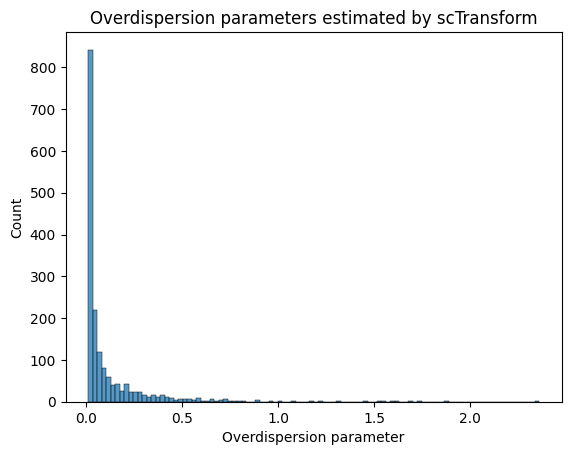

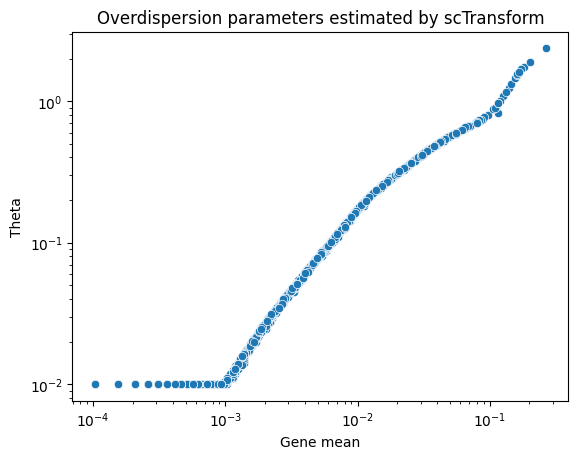

In [34]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log", yscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

In [35]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [36]:
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)
if is_overdispersed:
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_gene.X = sps.csr_matrix(np.sqrt(data_gene.X.toarray()))
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))

data_gene.layers["vst_counts"] = data_gene.X.copy()
sc.pp.scale(data_gene, max_value=10, zero_center=True)
# data_gene.X[np.isnan(data_gene.X)] = 0
sc.tl.pca(data_gene, svd_solver='arpack')

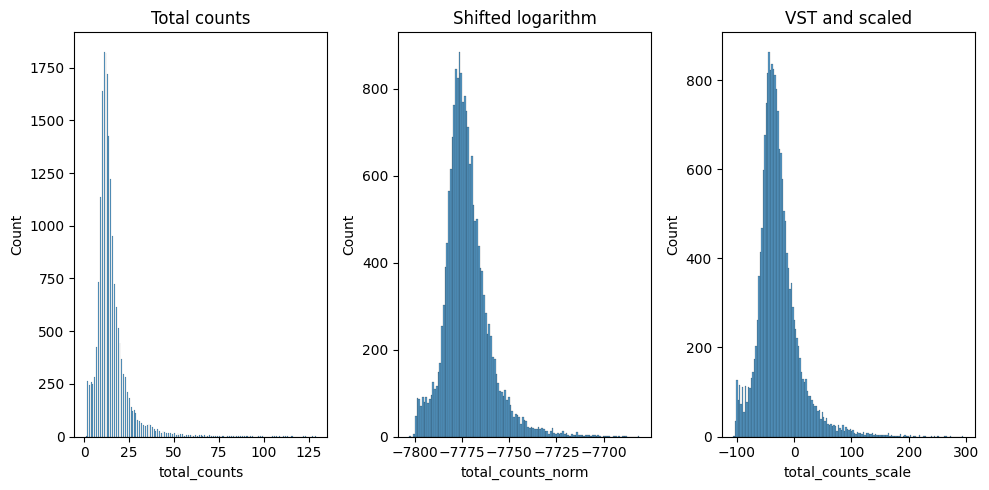

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

In [38]:
if is_overdispersed:
    data_dist = "NB"
else:
    data_dist = "Poi"
data_train, data_test = cs.countsplit_adata(data_gene, data_dist=data_dist, beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 19079 × 1616
    obs: 'treatment', 'replicate', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'outlier', 'total_counts_norm', 'total_counts_scale', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'log1p_mean_counts', 'log1p_total_counts', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    layers: 'counts'


In [39]:
# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
if is_overdispersed:
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_train.X = sps.csr_matrix(np.sqrt(data_train.X.toarray()))
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
if is_overdispersed:
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_test.X = sps.csr_matrix(np.sqrt(data_test.X.toarray()))
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

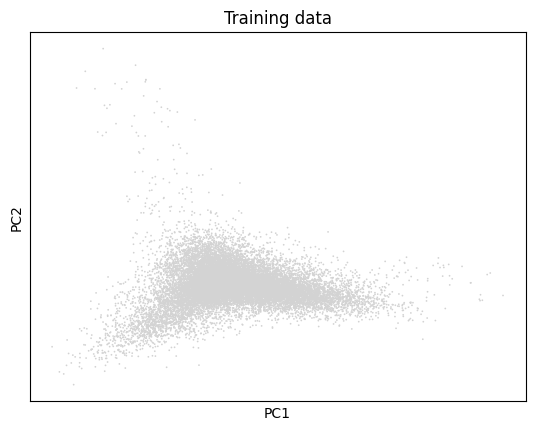

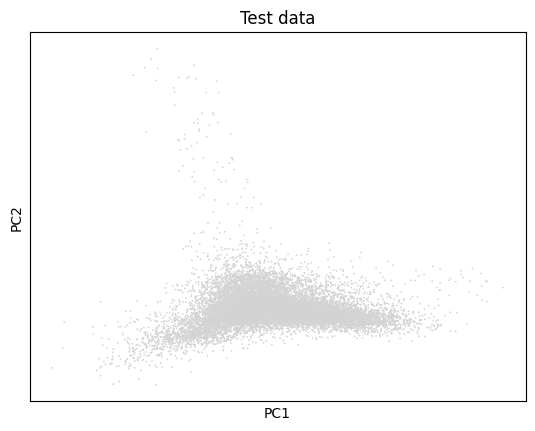

In [40]:
sc.pl.pca(data_train, title="Training data")
plt.show()

sc.pl.pca(data_test, title="Test data")
plt.show()

### Principal component selection

In [41]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

Optimal number of PCs:3


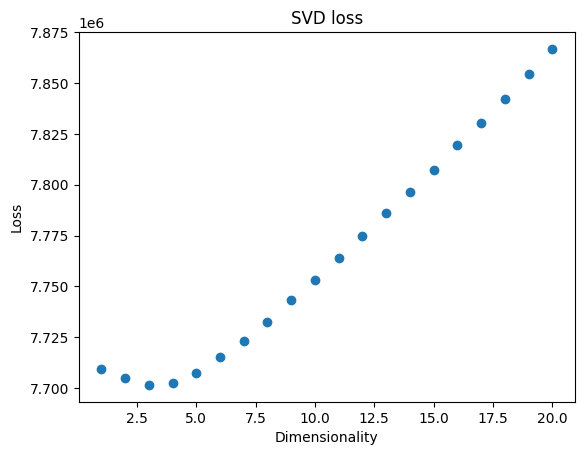

In [42]:
plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.xlabel("Dimensionality")
plt.ylabel("Loss")
plt.show()

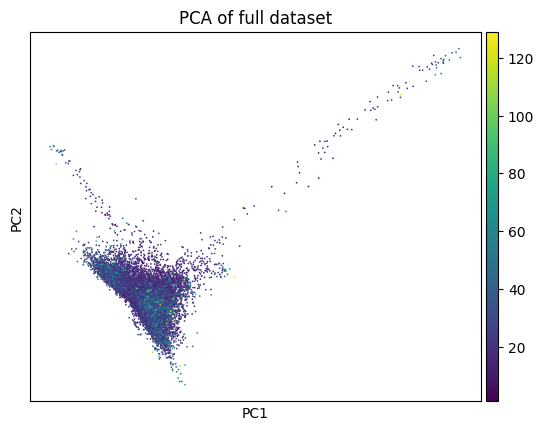

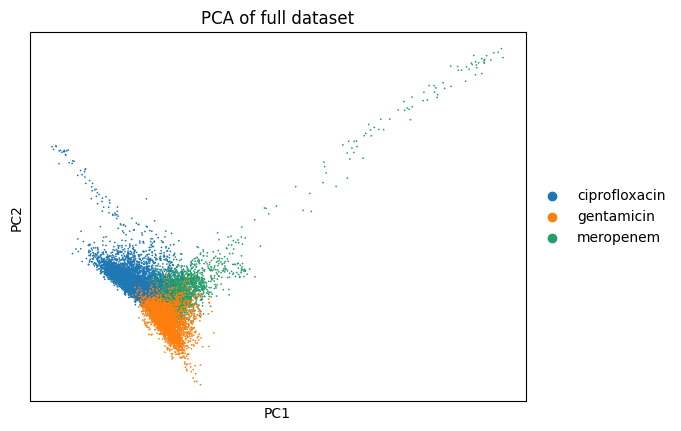

In [45]:
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", title="PCA of full dataset")
plt.show()

sc.pl.pca(data_gene, color="treatment", cmap="viridis", title="PCA of full dataset")
plt.show()

In [44]:
data_gene.uns["BacSC_params"] = {"k_opt": k_opt}

## Selection of optimal number of neighbors and optimal UMAP scale via scDEED

In [46]:
rng = np.random.default_rng()
seed = rng.choice(1000)
print(seed)

355


In [47]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(data_gene, n_neighborss, min_dists, n_pcs=k_opt, rng_seed=seed, embedding_method="UMAP", similarity_percent=0.5, save_path="S3_filtered_scdeed_temp")

calculating (10, 0.05) - run 1/85
calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 

Optimal number of neighbors: 20
Optimal min_dist: 0.05


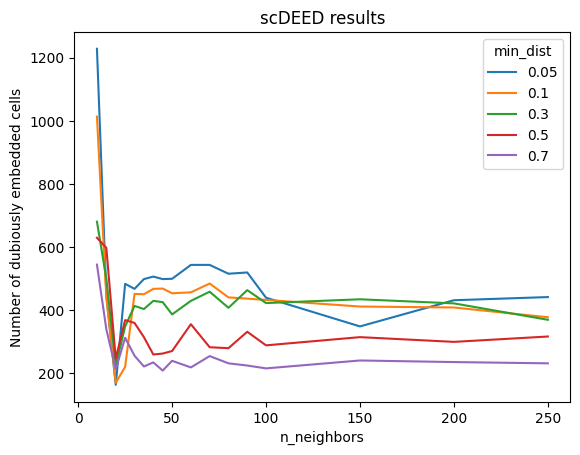

In [48]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [49]:
# k_opt = data_gene.uns["BacSC_params"]["k_opt"]
# n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
# min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]


k_opt = 3
n_neighbors_opt = 20
min_dist_opt = 0.05

In [50]:
data_gene.uns["BacSC_params"]["n_neighbors_opt"] = n_neighbors_opt
data_gene.uns["BacSC_params"]["min_dist_opt"] = min_dist_opt

In [51]:
sc.pp.neighbors(data_gene, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_gene, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=3456)


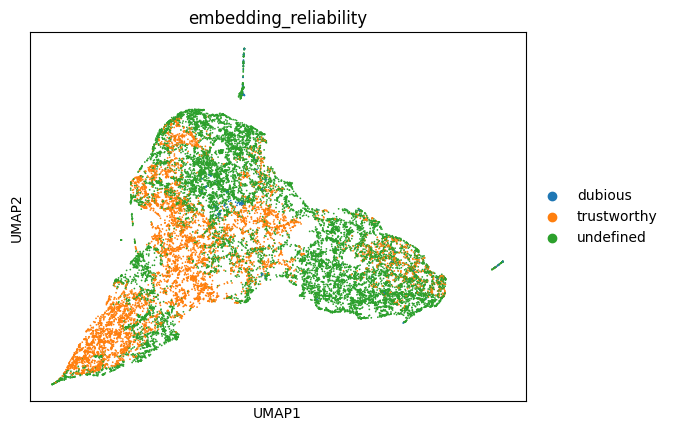

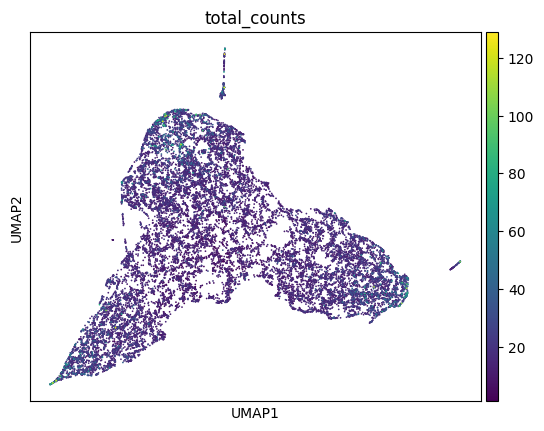

In [52]:
sc.pl.umap(data_gene, color="embedding_reliability", alpha=1)
plt.show()

sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

In [53]:
data_gene.write(data_path + "/antibiotics_data_processed.h5ad")


## Clustering

### Train/test-split for clustering

In [54]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

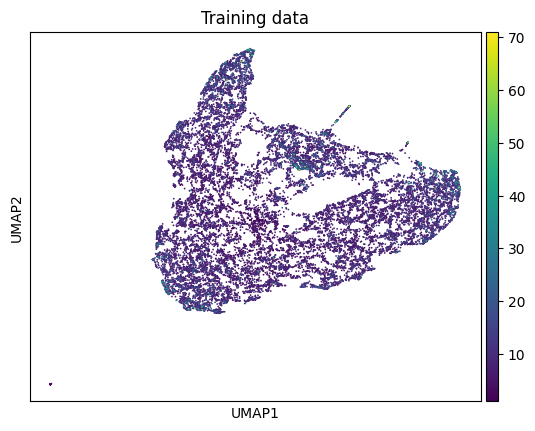

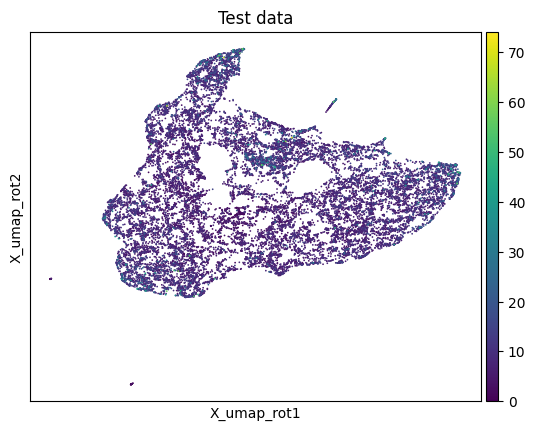

In [55]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

### Apply clustering with array of resolutions

In [57]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden", random_state=5678)

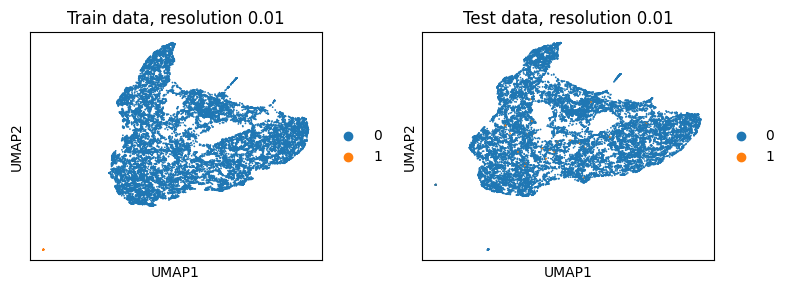

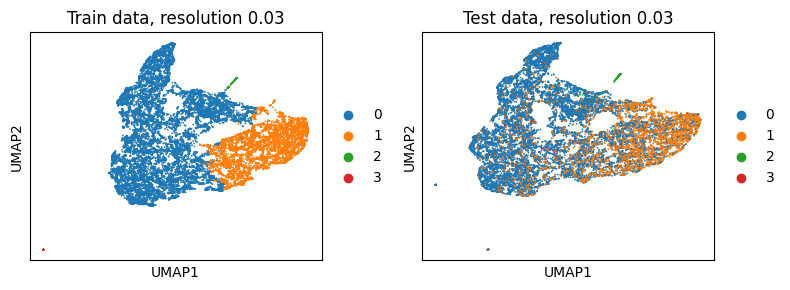

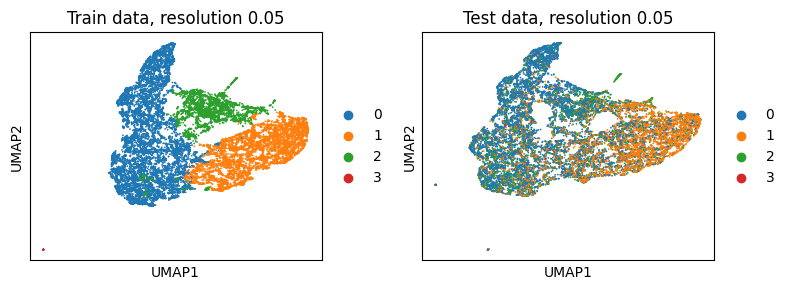

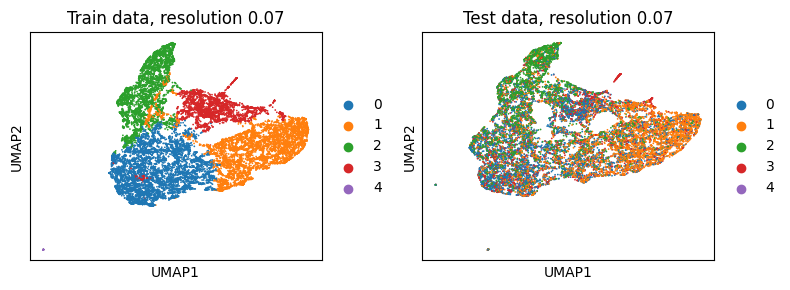

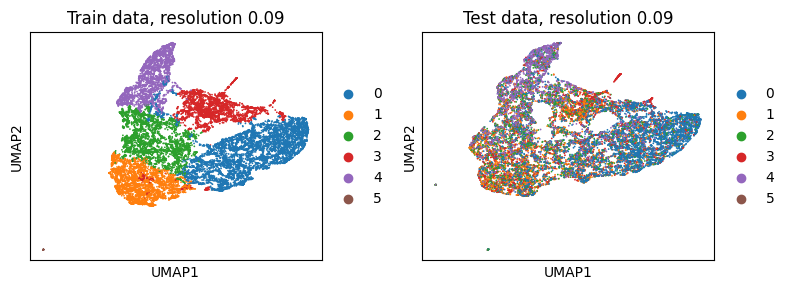

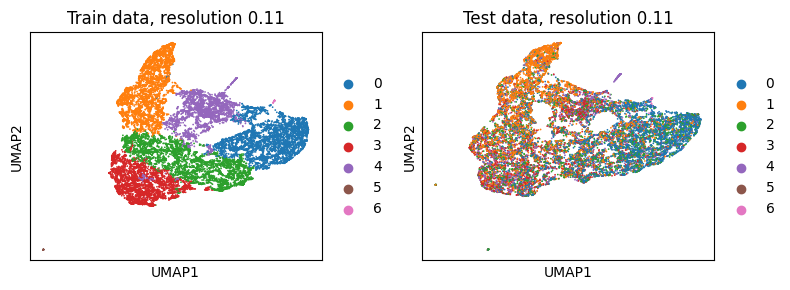

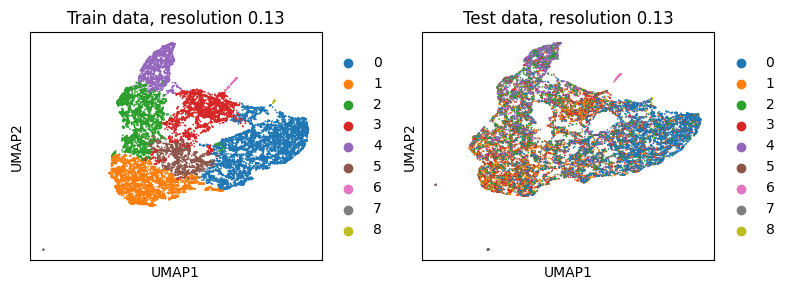

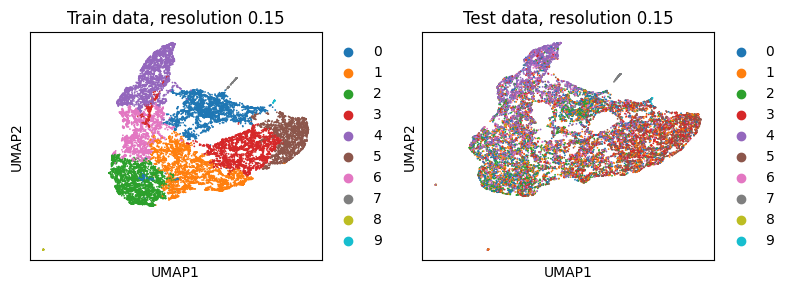

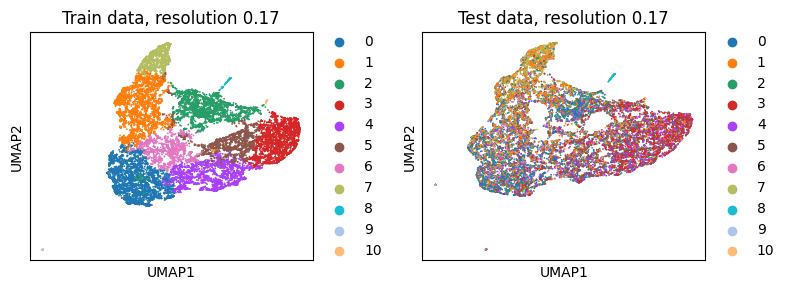

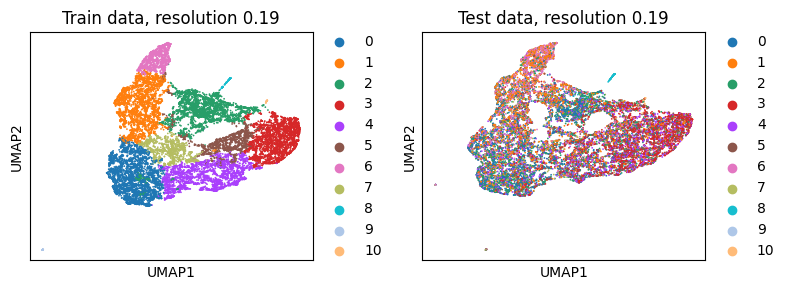

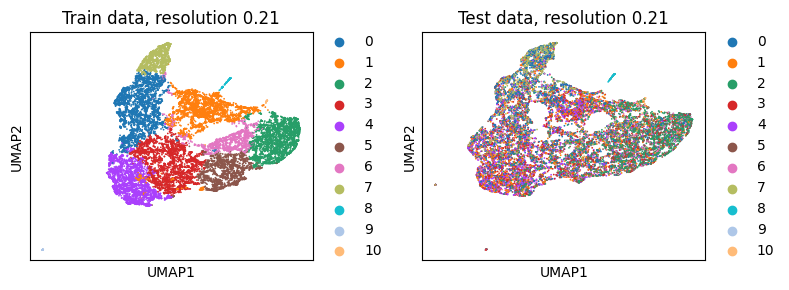

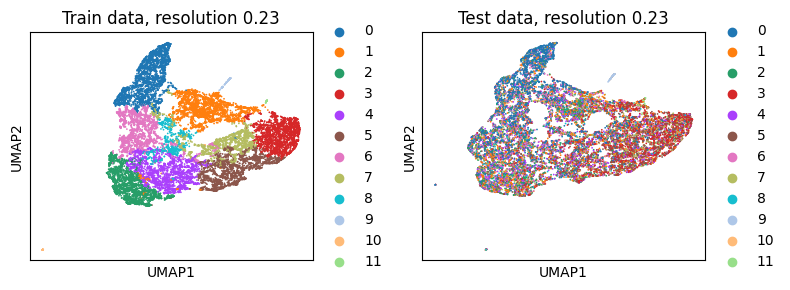

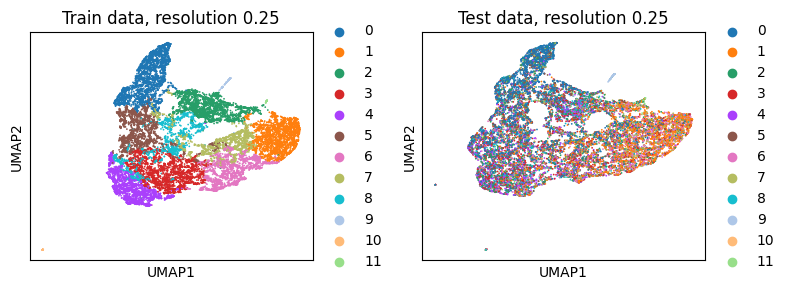

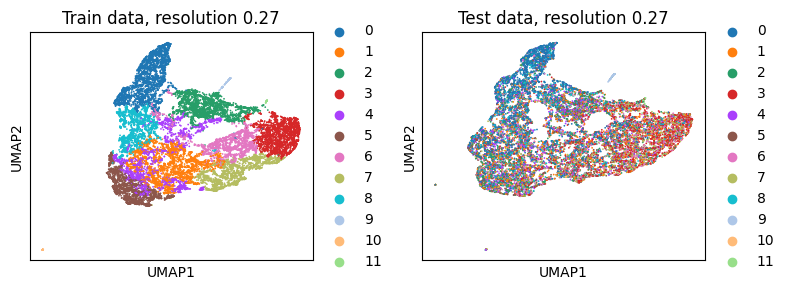

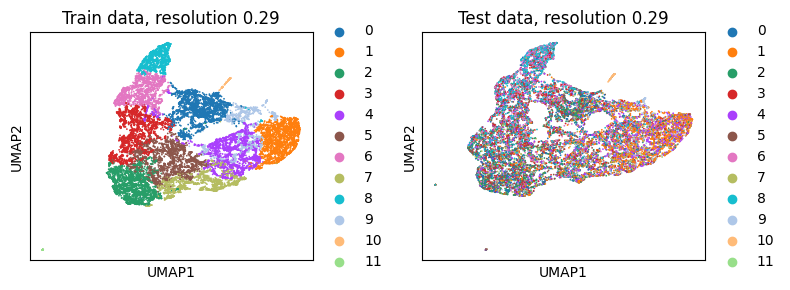

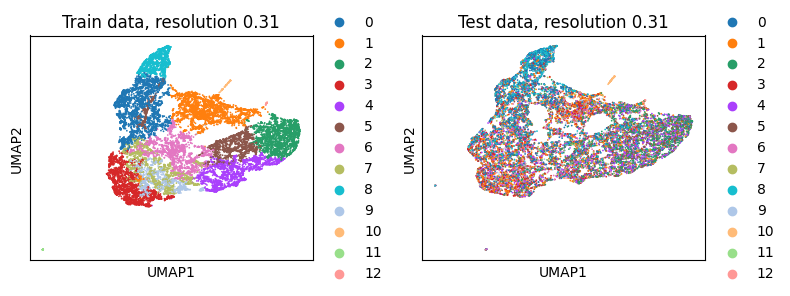

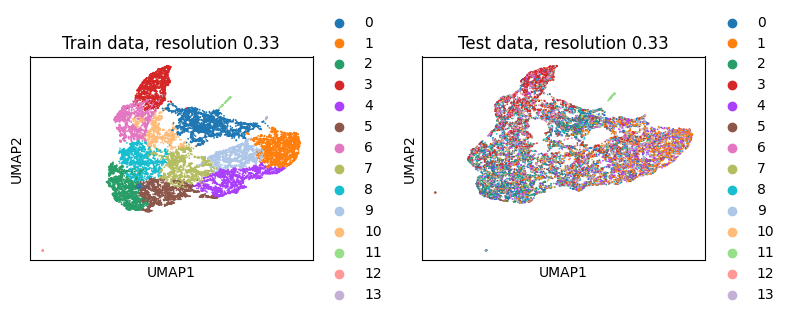

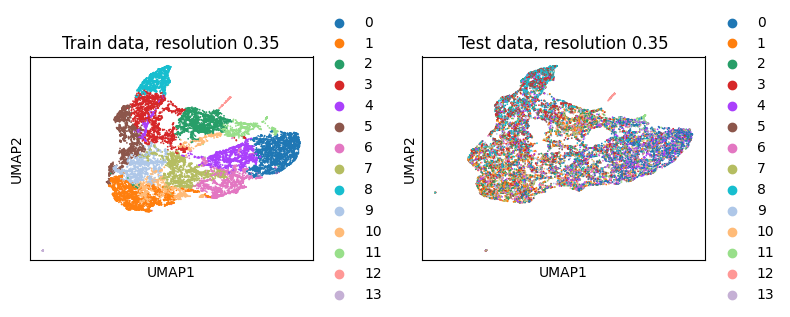

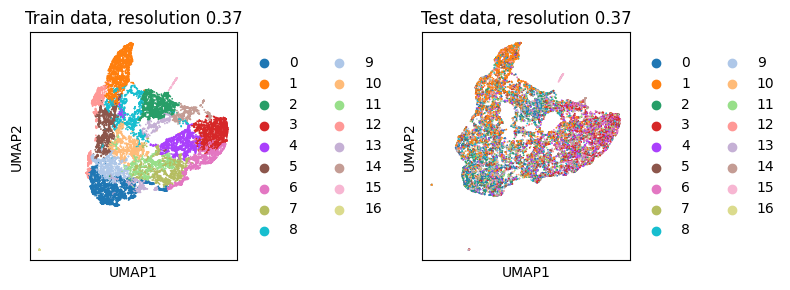

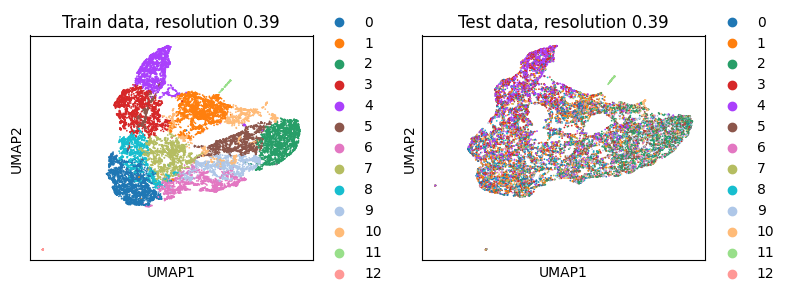

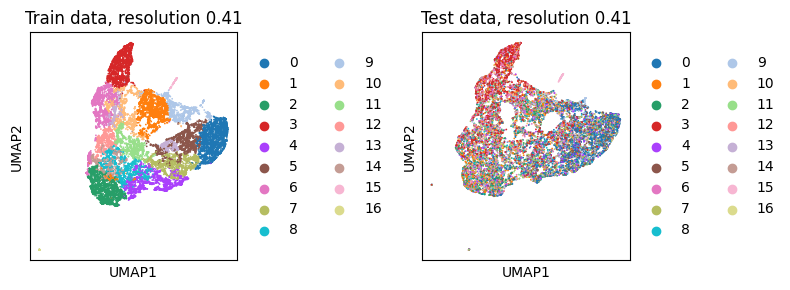

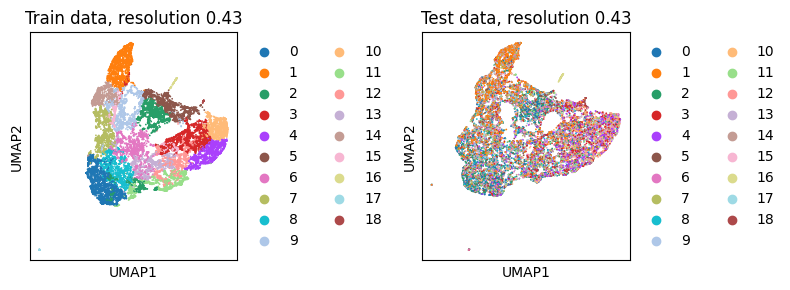

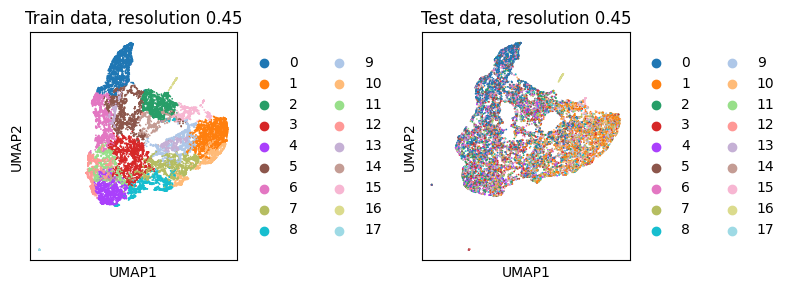

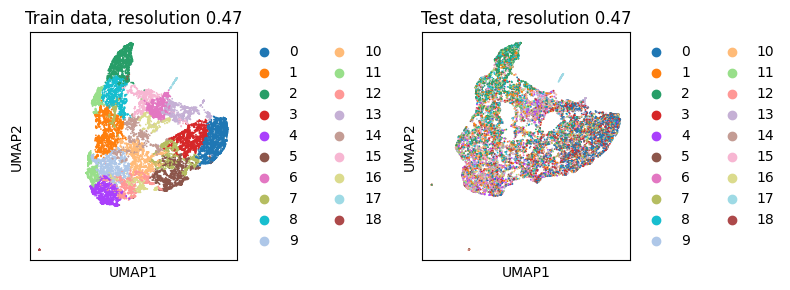

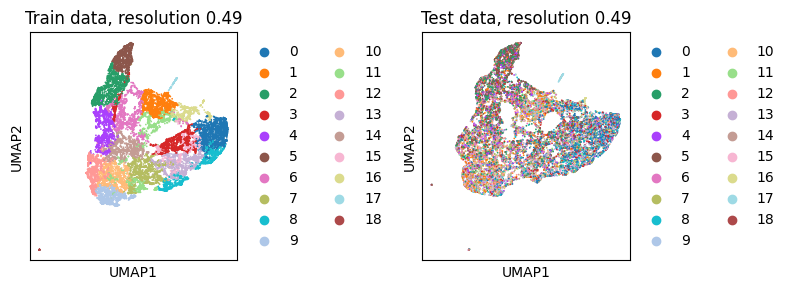

In [58]:
for resolution in resolutions:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sc.pl.umap(data_train, color=f"leiden_res{resolution}", ax=ax[0], title=f"Train data, resolution {resolution}", show=False)
    sc.pl.embedding(data_test, basis="X_umap_rot", color=f"leiden_res{resolution}", ax=ax[1], title=f"Test data, resolution {resolution}", show=False)
    ax[1].set_xlabel("UMAP1")
    ax[1].set_ylabel("UMAP2")
    plt.tight_layout()
    plt.show()

Modularities

In [59]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions)

print(f"Optimal resolution {res_opt}")
data_gene.uns["BacSC_params"]["res_opt"] = res_opt


resolution: 0.01 - clusters: 2 - Train: 0.49 - Test: 0.486 - Random: 0.486
resolution: 0.03 - clusters: 4 - Train: 0.475 - Test: 0.331 - Random: 0.271
resolution: 0.05 - clusters: 4 - Train: 0.466 - Test: 0.231 - Random: 0.175
resolution: 0.07 - clusters: 5 - Train: 0.464 - Test: 0.176 - Random: 0.115
resolution: 0.09 - clusters: 6 - Train: 0.458 - Test: 0.147 - Random: 0.091
resolution: 0.11 - clusters: 7 - Train: 0.455 - Test: 0.134 - Random: 0.079
resolution: 0.13 - clusters: 9 - Train: 0.451 - Test: 0.129 - Random: 0.073
resolution: 0.15 - clusters: 10 - Train: 0.45 - Test: 0.09 - Random: 0.05
resolution: 0.17 - clusters: 11 - Train: 0.448 - Test: 0.082 - Random: 0.045
resolution: 0.19 - clusters: 11 - Train: 0.444 - Test: 0.082 - Random: 0.043
resolution: 0.21 - clusters: 11 - Train: 0.442 - Test: 0.076 - Random: 0.039
resolution: 0.23 - clusters: 12 - Train: 0.44 - Test: 0.071 - Random: 0.032
resolution: 0.25 - clusters: 12 - Train: 0.437 - Test: 0.068 - Random: 0.029
resolution:

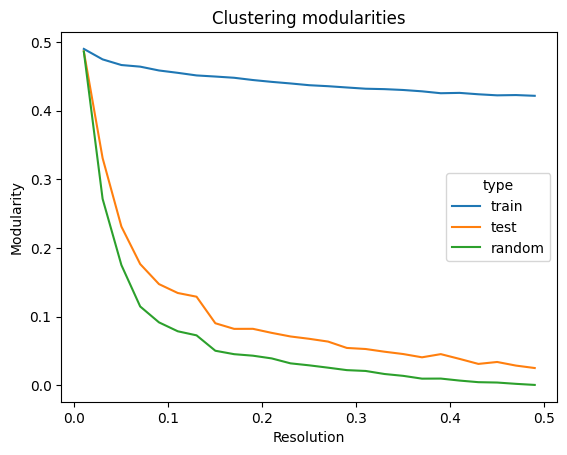

In [60]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Modularity")
plt.show()

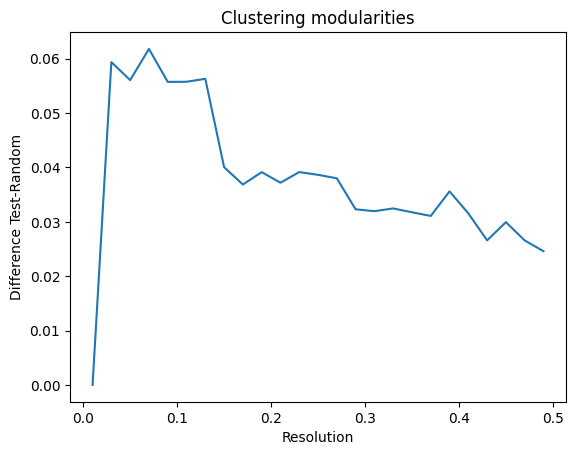

In [61]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Difference Test-Random")
plt.show()

## Cluster analysis

Optimal Leiden resolution: Maximal difference between random and test

In [62]:
sc.tl.leiden(data_gene, resolution=res_opt, key_added="leiden_opt")

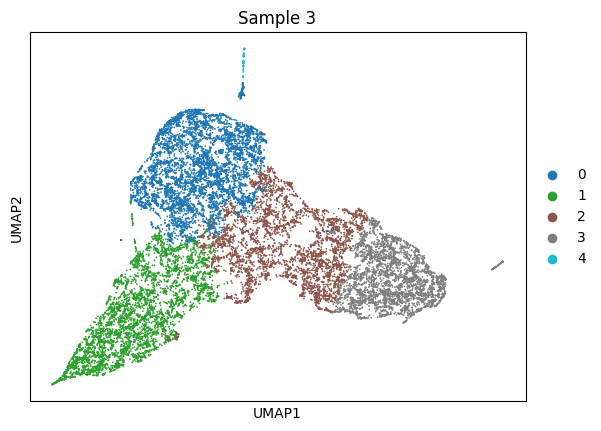

In [63]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

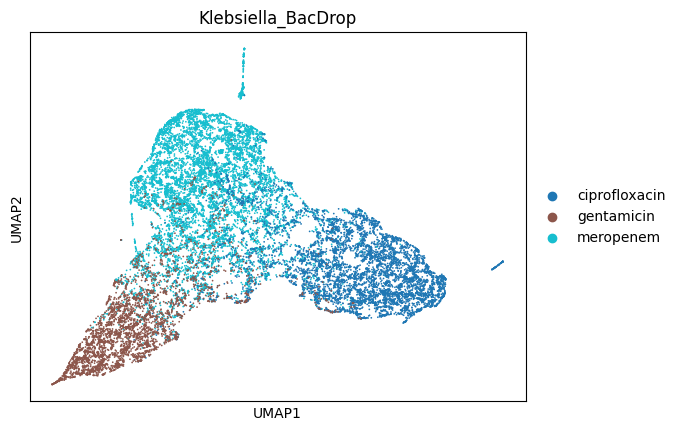

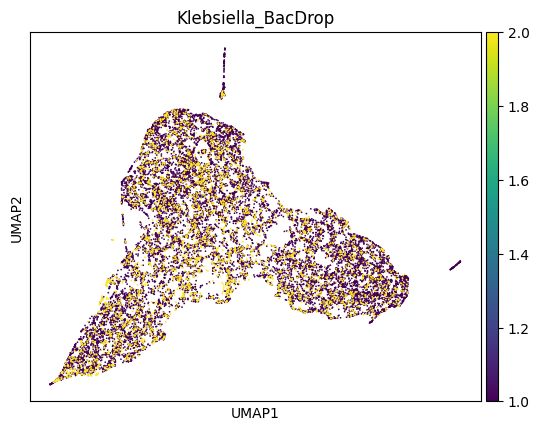

In [69]:
sc.pl.umap(data_gene, color="treatment", palette="tab10", title="Klebsiella_BacDrop")
plt.show()
sc.pl.umap(data_gene, color="replicate", palette="tab10", title="Klebsiella_BacDrop")
plt.show()

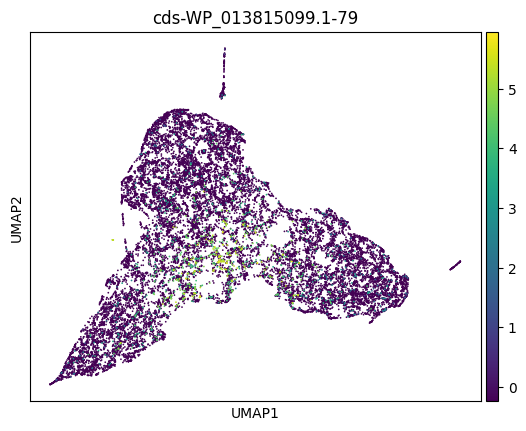

In [94]:
tag = "cds-WP_013815099.1-79"
sc.pl.umap(data_gene, color=tag)
plt.show()

In [92]:
data_gene.write(data_path + "/antibiotics_data_processed.h5ad")

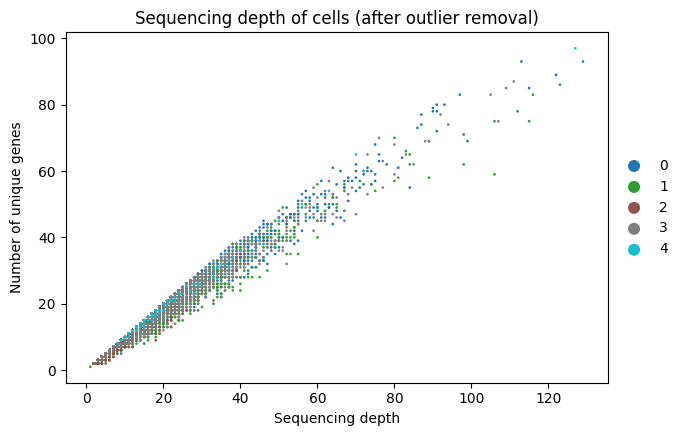

In [65]:
sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

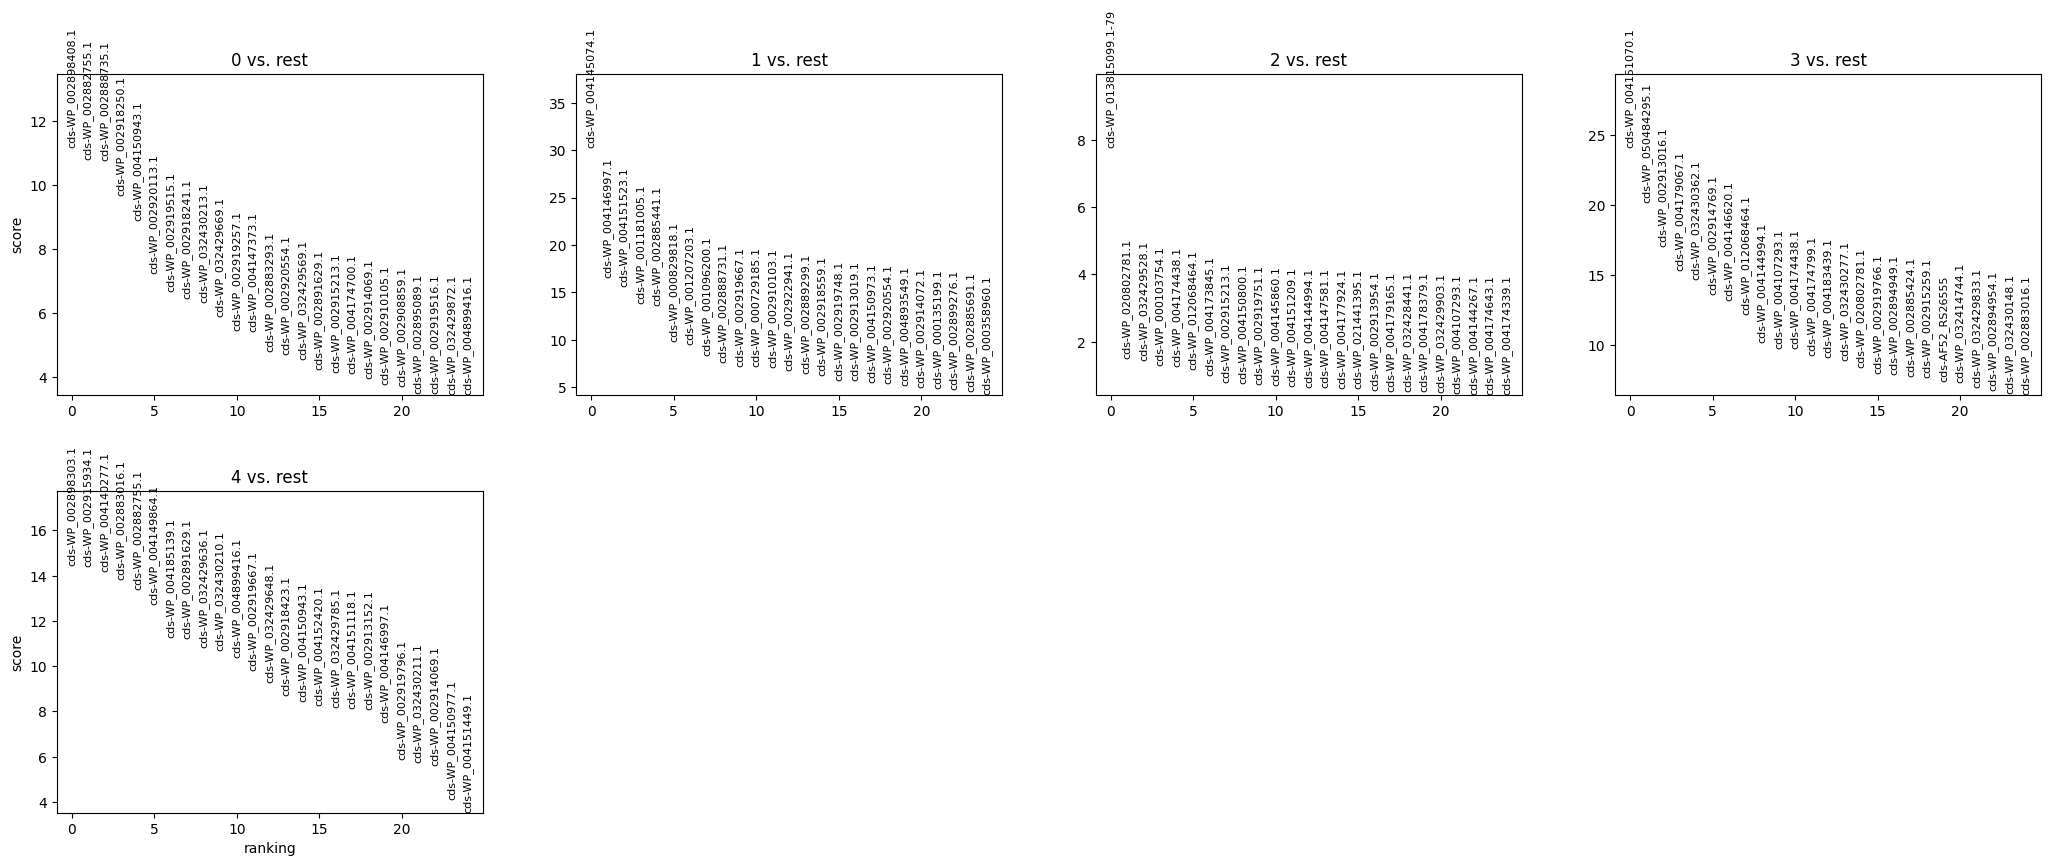

In [66]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

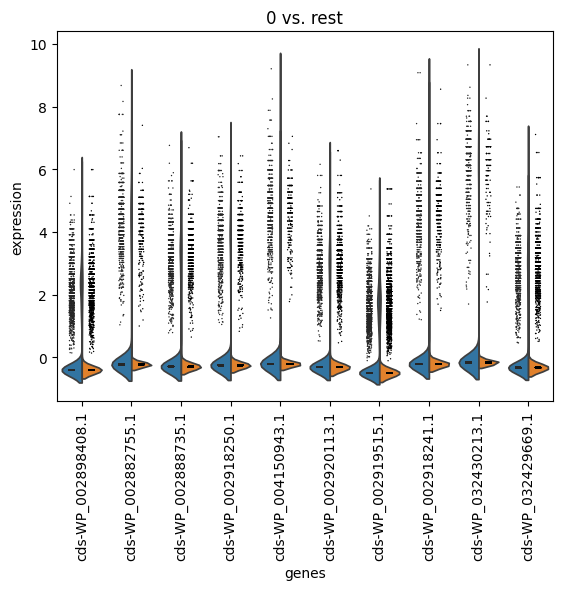

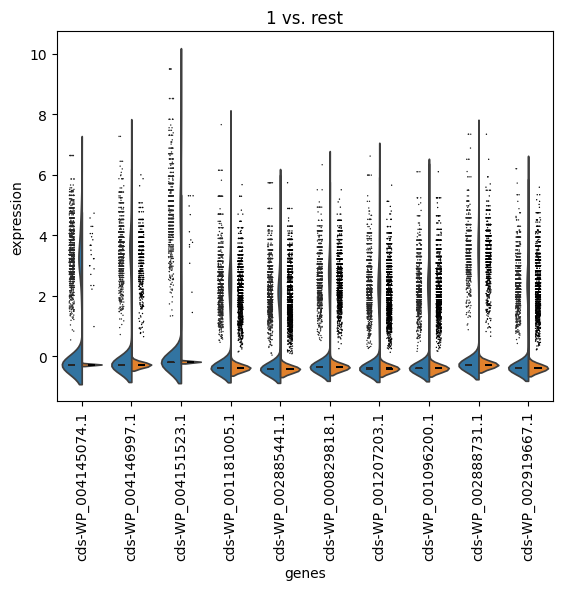

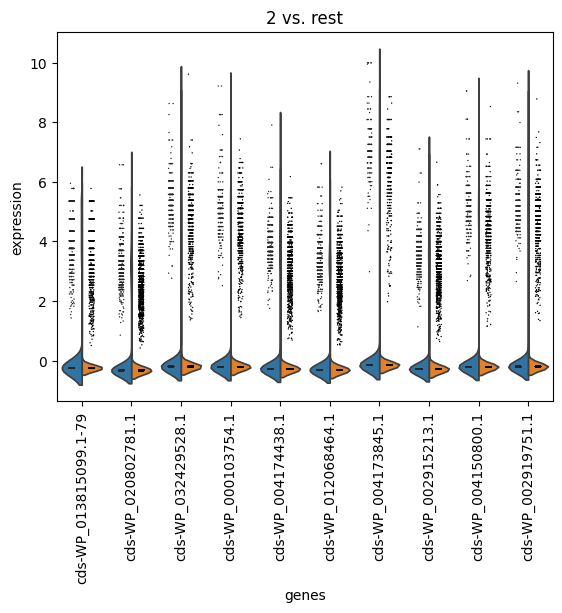

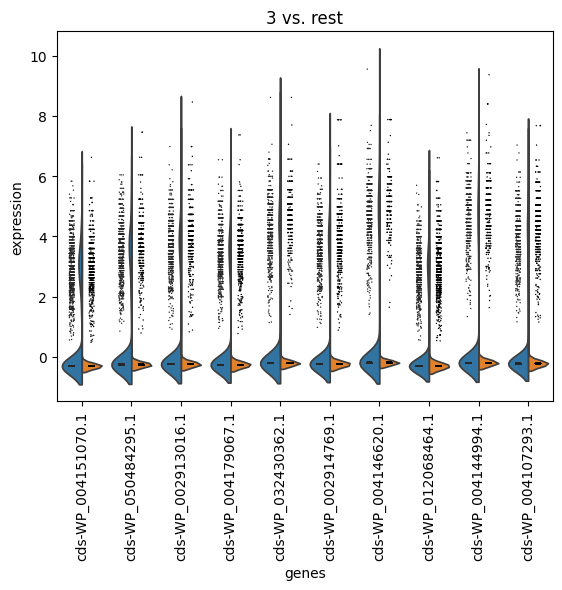

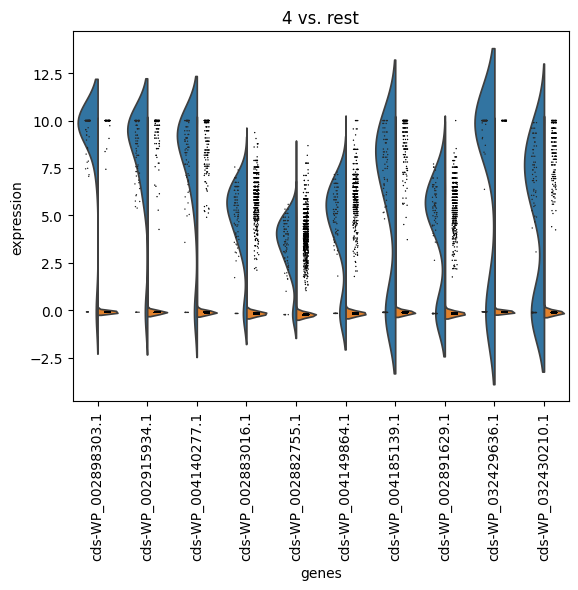

In [67]:
nclust = len(np.unique(data_gene.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_gene, groups=str(i), n_genes=10)

In [87]:
data_gene.layers["counts"]

<19369x1716 sparse matrix of type '<class 'numpy.float32'>'
	with 265963 stored elements in Compressed Sparse Row format>